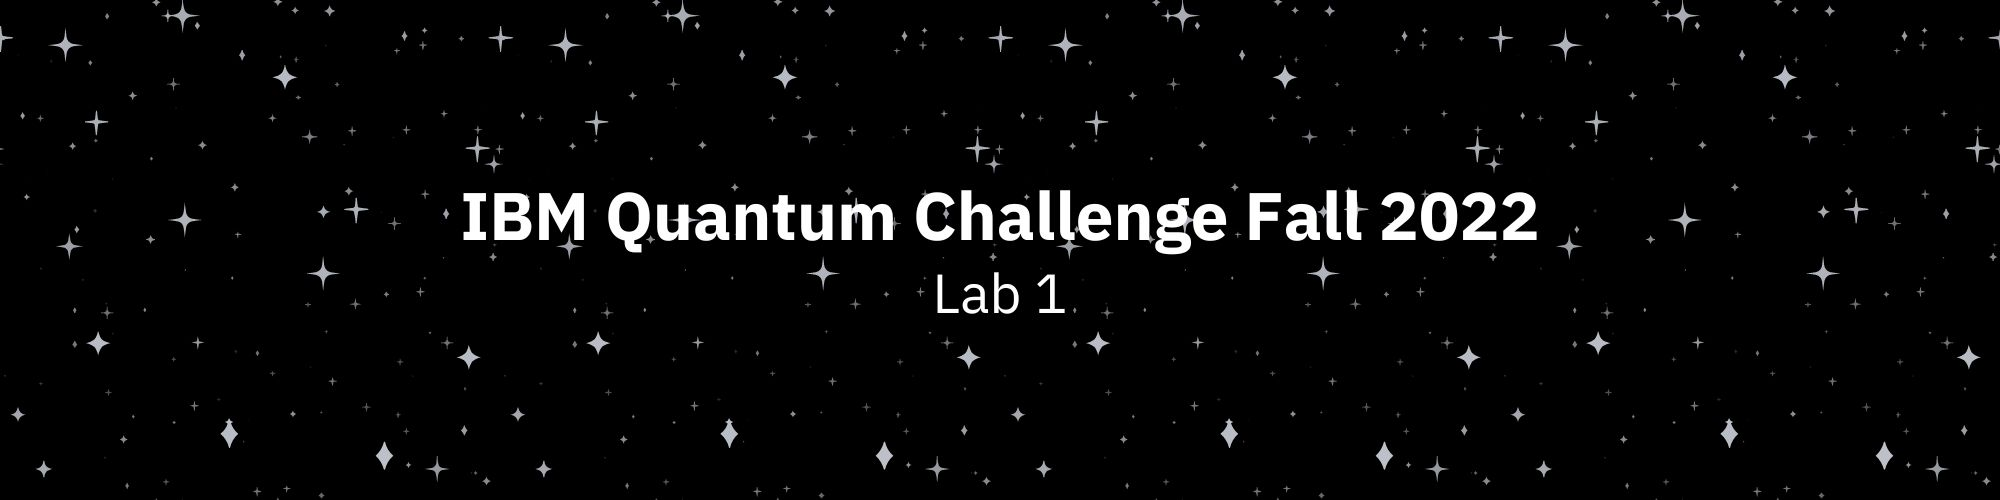

# 重ね合わせと干渉

このLabでは量子計算の基本戦略として、重ね合わせを利用した並列計算と確率振幅の干渉の利用を学びます。  
また、これらを利用することで量子計算の優位性を示したベルンシュタイン・ヴァジラニのアルゴリズムを実装します。

In [1]:
import qiskit
qiskit.__version__

'1.4.2'

In [2]:
#####  ライブラリーの導入
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

```{important}

```

## ベルンシュタイン・ヴァジラニのアルゴリズム
ベルンシュタイン・ヴァジラニのアルゴリズムは、量子コンピューターを複雑な問題に適用した場合に優位性があることを示した量子アルゴリズムのうちの一つです。

秘密のビット文字列 $s = s_1, s_2, \cdots s_n$ が与えられたとき、入力 $x = x_1, x_2, \cdots x_n$ に対してパラメータ $s$ を持つオラクル（ブラックボックス関数） $f$ が与えられたとき、何回か $x$ を問い合わせて秘密のビット文字列 $s$ を推定する問題を考えます。

$$ f(x) = s ⋅ x (\mathrm{mod} 2) $$

## 古典的な解法
古典的には秘密のビット文字列 $s$ の各ビットについて、以下の入力をオラクルに問合せすることで洗い出されます。

|Input(x)|
|:-----:|
|100...0|
|010...0|
|001...0|
|000...1|

例えば、$x = 1000...0$  により $s$ の一番小さい桁のビットをみつけることができます。 $x = 0100...0$ により  $s$ の二番目に小さい桁のビットをみつけることができます。  
つまり、ビット文字列を見るけるには関数 $f(x)$ を $n$ 回呼び出す必要があります。

## 量子的な解法
しかし、量子コンピューターを使用すると、関数を **1 回呼び出すだけ** で100%の信頼度でこの問題を解くことができます。

アルゴリズムは非常にシンプルです。
1. 入力量子ビットを状態 $|0\rangle^{\otimes n}$ に初期化し、出力量子ビットを $|-\rangle$ に初期化する。
2. アダマールゲートを入力レジスターに適用する。
3. オラクルに問い合わせる。
4. アダマールゲートを入力レジスターに適用する。
5. 測定する。

```{note}
ベルンシュタイン・ヴァジラニ アルゴリズムについて詳しくは、Qiskit Youtubeにある[Coding with Qiskit Season 1のエピソード6](https://youtu.be/sqJIpHYl7oo)が参考になります。
```

## アルゴリズムの実装
以下に、ベルンシュタイン・ヴァジラニのアルゴリズムが $n=3$ の量子ビットを基に秘密のビット文字列 $s=001$ を見つける例を実装してみましょう。

In [3]:
hidden = "001"
n = len(hidden)

print(n)

3


この隠れたビット文字列には、3つの入力量子ビットと1つの出力量子ビットが必要です。

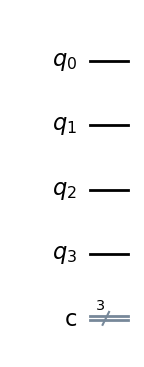

In [4]:
# Make a quantum circuit
qc = QuantumCircuit(n+1, n)
display(qc.draw(output="mpl"))

**ステップ 1**.   
入力量子ビットを状態 $|0\rangle^{\otimes n}$ に初期化し、出力量子ビットを $|-\rangle$ に初期化します。

$$\lvert \psi_0 \rangle |-\rangle = \lvert 000 \rangle |-\rangle$$

最初に、すべての量子ビットは $|0\rangle$ として初期化されるため、入力量子ビットにゲートを適用する必要はありません。 ただし、出力量子ビットの状態は $|-\rangle$ として初期化する必要があります。 そのために、X ゲートを適用してからアダマールゲートを適用します。

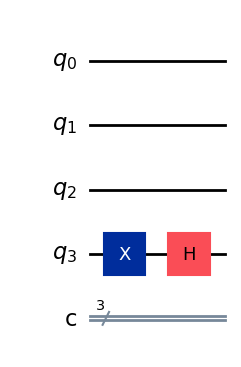

In [5]:
qc.x(3)
qc.h(3)
display(qc.draw(output="mpl"))

**ステップ 2**.   
アダマールゲートを入力レジスターに適用します。  
各入力量子ビットにアダマールゲートを適用します。

$$|\psi_2 \rangle |-\rangle = (-1)^{000\cdot 001}|\psi_1 \rangle |-\rangle = \frac{1}{\sqrt{2^3}} \left( (-1)^{000\cdot 001}|000 \rangle + \lvert 001 \rangle + \lvert 010 \rangle + \lvert 011 \rangle + \lvert 100 \rangle + \lvert 101 \rangle + \lvert 110 \rangle + \lvert 111 \rangle \right) |-\rangle $$


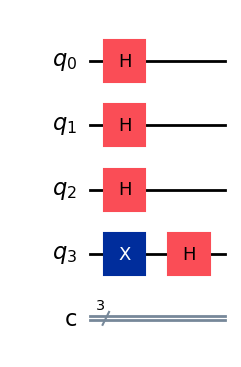

In [6]:
qc.h(0)
qc.h(1)
qc.h(2)
display(qc.draw(output="mpl"))

**ステップ 3**.   
オラクルに問い合わせます。文字列 $s=001$ に対して、量子オラクルは $ |x \rangle \xrightarrow{f_s} (-1)^{x\cdot 001} |x \rangle. $ の演算を行います。 

\begin{align*}
\lvert \psi_3 \rangle |-\rangle &= \frac{1}{\sqrt{2^3}} \left( (-1)^{000\cdot 001}|000 \rangle + (-1)^{001\cdot 001}|001 \rangle + (-1)^{010\cdot 001}|010 \rangle + (-1)^{011\cdot 001}|011 \rangle + (-1)^{100\cdot 001}|100 \rangle + (-1)^{001\cdot 001}|101 \rangle + (-1)^{110\cdot 001}|110 \rangle + (-1)^{111\cdot 001}|111 \rangle \right) |-\rangle \\
&= \frac{1}{\sqrt{2^3}} \left( |000 \rangle - |001 \rangle + |010 \rangle - |011 \rangle + |100 \rangle - |101 \rangle + |110 \rangle - |111 \rangle \right) |-\rangle
\end{align*}

CNOTゲートを使用してオラクルにクエリーを実行します。隠し回路が"001"であるため、CNOTゲートを量子ビット0と出力ゲートに適用します。

> Qiskitでは、ビットの番号が **右から左へ** 割り当てられます。

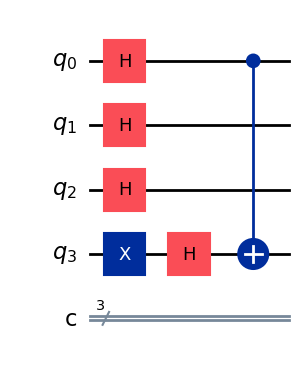

In [7]:
qc.cx(0,3)
display(qc.draw(output="mpl"))

**ステップ 4**.   
アダマールゲートを入力レジスターに適用します。  
各入力量子ビットにアダマールゲートを再度適用します。

$$|\psi_4 \rangle |1 \rangle = \lvert 001 \rangle |1 \rangle$$

このように、 $|001 \rangle$ 以外の確率振幅が干渉によって打ち消し合うことで、基底ベクトルの個数を絞ることが出来ています。
ベルンシュタイン・ヴァジラニのアルゴリズムは、量子の重ね合わせを利用した並列計算と、確率振幅の干渉をうまく使うことで量子計算の優位性を示しています。

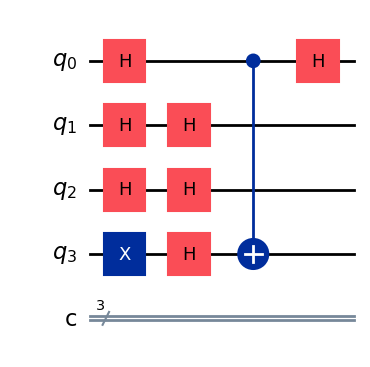

In [8]:
qc.h(0)
qc.h(1)
qc.h(2)
display(qc.draw(output="mpl"))

**ステップ 5**.   
測定します。

[`measure`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.Measure) メソッドですべての入力量子ビットを測定します。

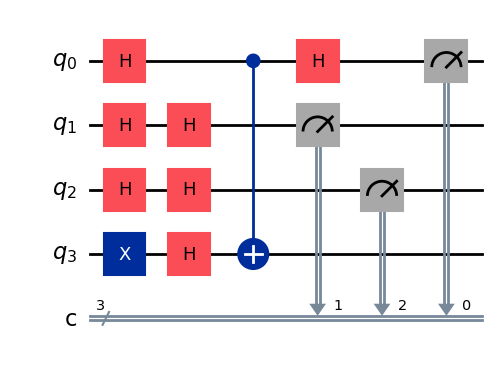

In [9]:
qc.measure(range(3), range(3))
display(qc.draw(output="mpl"))

回路はシミュレーターで実行できます。下のセルを実行すると、結果を確認できます。

In [10]:
# Use local simulator
aer_sim = AerSimulator()
results = aer_sim.run(qc).result()
answer = results.get_counts()

print(answer)

{'001': 1024}


結果には、最初に設定した隠れたビット文字列"001"が表示されています。

## Exercise: ベルンシュタイン・ヴァジラニ関数の実装
````{admonition} Exercise

ベルンシュタイン・ヴァジラニ関数を作ってみましょう。パラメーターは1つだけで、これが秘密のビット文字列です。このビット文字列は "0 "と "1 "から成り立っています。  
以下のコードブロックでは、全ての秘密のビット文字列でうまく動作する一般的な関数を構築する必要があります。

```python
def bernstein_vazirani(string):
    
    ##### Save the length of string
    string_length = len(string)
    
    ##### Make a quantum circuit
    qc = QuantumCircuit(string_length+1, string_length)
    
    ##### Initialize each input qubit to apply a Hadamard gate and output qubit to |->
    
    ###### build your code here #####
    
    ###### Apply an oracle for the given string
    ###### Note: In Qiskit, numbers are assigned to the bits in a string from right to left
    

    ###### build your code here #####

    
    ###### Apply Hadamard gates after querying the oracle
    

    ###### build your code here ######
    
    ###### Measurement
    qc.measure(range(string_length), range(string_length))
    
    return qc
```
````

In [11]:
def bernstein_vazirani(string):

    # Save the length of string
    string_length = len(string)

    # Make a quantum circuit
    qc = QuantumCircuit(string_length+1, string_length)

    # 1. Initialize each input qubit to apply a Hadamard gate and output qubit to |->
    qc.x(string_length)
    qc.h(range(string_length+1))
    qc.barrier()

    # 2. Apply an oracle for the given string
    # Note: In Qiskit, numbers are assigned to the bits in a string from right to left 
    string = string[::-1] # Reverse password to fit qiskit's qubit ordering
    for q in range(string_length):
        if string[q] == '1':
            qc.cx(q, string_length)
    qc.barrier()

    # 3. Apply Hadamard gates after querying the oracle
    qc.h(range(string_length))

    # Measurement
    qc.measure(range(string_length), range(string_length))

    return qc

```{toggle} 解説

1. 最初に初期化を行います。入力量子ビット数は`string_length`、出力量子ビット数は`1`になります。初期化では、`qc.h(range(string_length+1))`で入力量子ビットと出力量子ビットにアダマールゲート、`qc.x(string_length)`で出力量子ビットを$\ket{-}$にします。
rangeを用いることで複数量子ビットにゲートを適用できます。

2. 次にオラクルを作成します。引数である`string`が1である場合(`string[q] == '1'`)、CNOTゲートを適用します。Qiskitでは、ビットの番号が右から左へ割り当てられるため、関数の入力であるstringの順番を`string = string[::-1]`で反転させます。

3. 最後に`qc.h(range(string_length))`で入力量子ビットにアダマールゲートを適用します。

```


ここで、上記の関数を呼び出して、定義されているベルンシュタイン・ヴァジラニ回路を構築します。

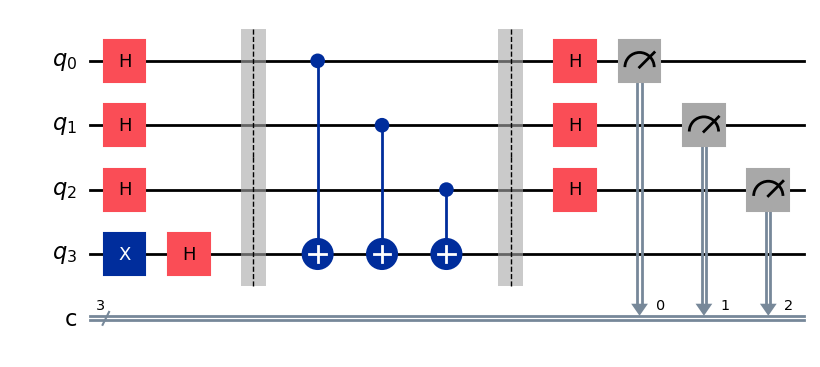

In [12]:
qc1 = bernstein_vazirani('111')
display(qc1.draw(output="mpl"))

この回路を実行する前に、先ほど述べたように、1つのSamplerセッションに対して複数の回路呼び出しと実行が可能です。そのことを示すために、もう1つベルンシュタイン・ヴァジラニ回路を作ることにします。

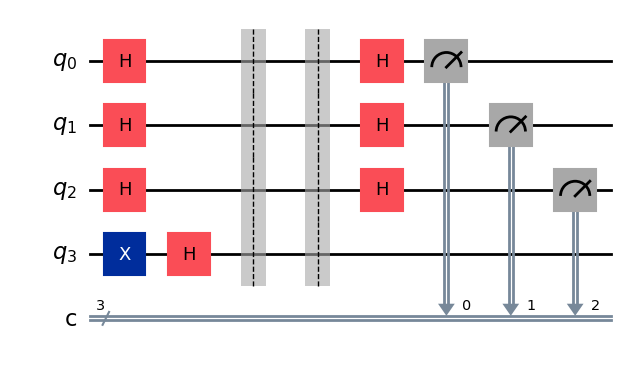

In [13]:
qc2 = bernstein_vazirani('000')
display(qc2.draw(output="mpl"))

## 回路を実行する

In [ ]:
backend = AerSimulator()
[backend.run(qc).result().get_counts() for qc in (qc1, qc2)]

[{'111': 1024}, {'000': 1024}]

この結果、各回路から2つの結果が得られます。  
最初の回路`qc1`の隠れ文字列は`111`であり、最初の結果は7（7は2進数で111）です。この確率は1.0であり、この回路は100%確実に7を返すということです。  
同様に、2番目の結果は0（0は2進数で000）であり、その確率も1.0です。

このように、回路を作るときに渡したビット列と同じ結果になります。どうしてこんなことが可能なのか、不思議に思われるかもしれません。下の画像を見てください：

![](./resources/2022-autumn-lab1-revers-cx.png)

4つのHゲートの間にCNOTゲートがあり、これは反転したCNOTゲートと同じす。これはキックバック（または位相キックバック）の例で、ゲートによってある量子ビットに加えられた固有値が、制御演算によって別の量子ビットに*キックバック*されるのです。これにより、ベルンシュタイン・ヴァジラニ回路は、隠されたビット列を明らかにすることができます。